# Imports

In [26]:
import sys
sys.path.append("../Face Detection")

import cv2
import face_detection
import glob
import importlib
import os
import zipfile

importlib.reload(face_detection)

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from face_detection import predict_detected_faces
from PIL import Image
from keras import initializers, regularizers, Sequential
from keras.applications import EfficientNetB0, InceptionV3, MobileNet, MobileNetV2, ResNet50, VGG16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import (
    AveragePooling2D, BatchNormalization, Conv2D, Dense, Dropout,
    Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D,
    SpatialDropout2D
)
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

tf.config.set_visible_devices(gpus[1], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Hyperparameter for the model

In [4]:
batch_size = 24
target_size = (224, 224)
learning_rate = 0.0001
kernel_s = (3, 3)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Data Augmentation

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

train_gen=train_datagen.flow_from_directory(
    'Train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen=valid_datagen.flow_from_directory(
    'Validate',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_gen=valid_datagen.flow_from_directory(
    'Test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 6400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# Plotting a batch of training data

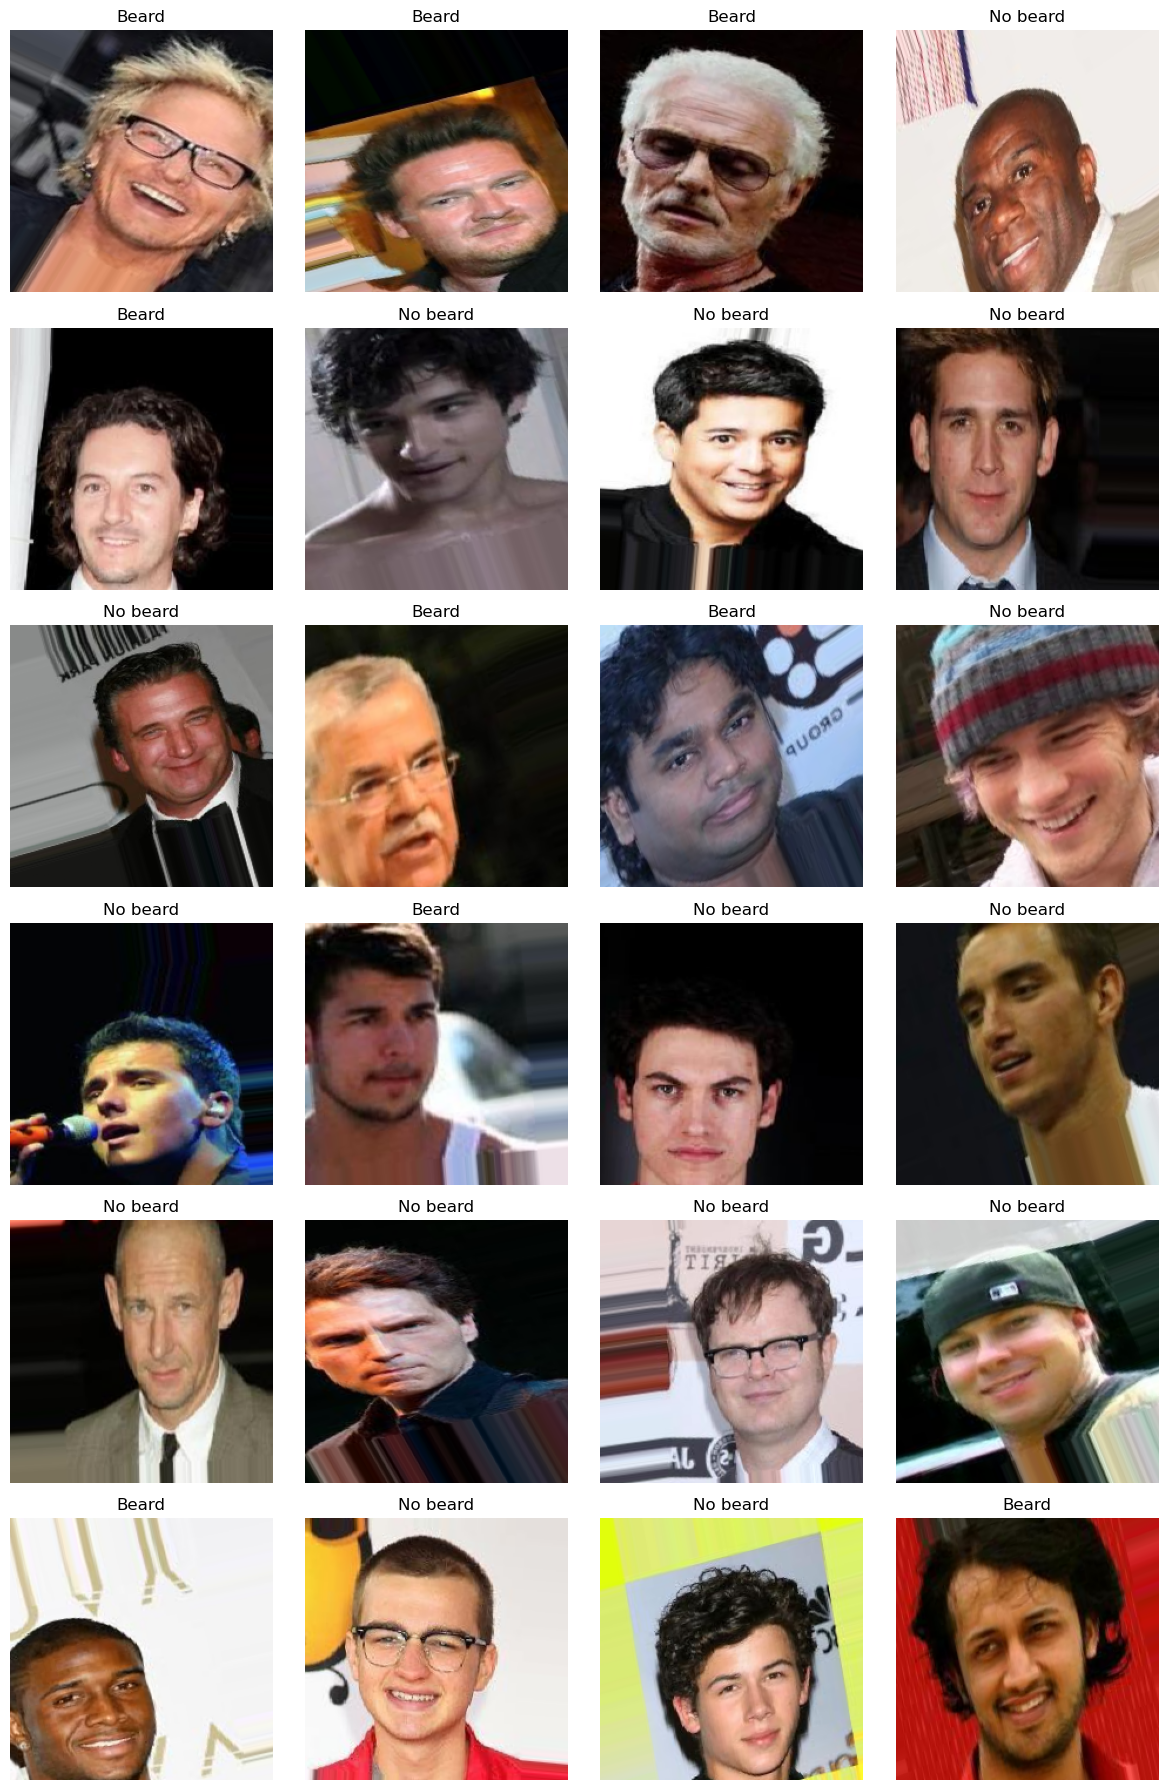

In [6]:
x_batch, y_batch = next(train_gen)
num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])
    label = "Beard" if y_batch[i] == 0 else "No beard"
    ax.set_title(label)
    ax.axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Set up and configure a model for training

In [7]:
# These two models are also not bad
# base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Is correct on the test data, but not on my own
# base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Works for my images, but isn't correct on the test data

# https://arxiv.org/abs/1409.4842 - Paper of the Inception architecture
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False 

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

2025-05-11 08:45:28.826608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46653 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:73:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1024)              52429824  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 74233633 (283.18 MB)
Trainable params: 59604161 (227.37 MB)
Non-trainable params: 14629472 (55.81 MB)
_________________________________________________________________


# Compile the model and start the training

In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(
    train_gen,
    batch_size=batch_size,
    epochs=40,
    validation_data=valid_gen,
    steps_per_epoch=100,
    callbacks=[early_stopping]
)

Epoch 1/40


2025-05-11 08:45:42.598291: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-05-11 08:45:46.498061: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe66032b910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-11 08:45:46.498107: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-05-11 08:45:46.504087: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746953146.631120   21338 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 41s 280ms/step - loss: 2.7586 - acc: 0.6095 - val_loss: 0.5982 - val_acc: 0.7475
Epoch 2/40
100/100 [==============================] - 23s 226ms/step - loss: 0.5377 - acc: 0.7245 - val_loss: 0.4335 - val_acc: 0.8225
Epoch 3/40
100/100 [==============================] - 23s 228ms/step - loss: 0.4785 - acc: 0.7663 - val_loss: 0.4032 - val_acc: 0.8325
Epoch 4/40
100/100 [==============================] - 23s 231ms/step - loss: 0.4703 - acc: 0.7858 - val_loss: 0.3983 - val_acc: 0.8313
Epoch 5/40
100/100 [==============================] - 23s 226ms/step - loss: 0.4675 - acc: 0.7804 - val_loss: 0.4234 - val_acc: 0.8150
Epoch 6/40
100/100 [==============================] - 22s 224ms/step - loss: 0.4457 - acc: 0.7950 - val_loss: 0.4030 - val_acc: 0.8200
Epoch 7/40
100/100 [==============================] - 22s 224ms/step - loss: 0.4456 - acc: 0.7875 - val_loss: 0.4074 - val_acc: 0.8238
Epoch 8/40
100/100 [==============================] - 23s 227ms/st

# Plot the results of the training

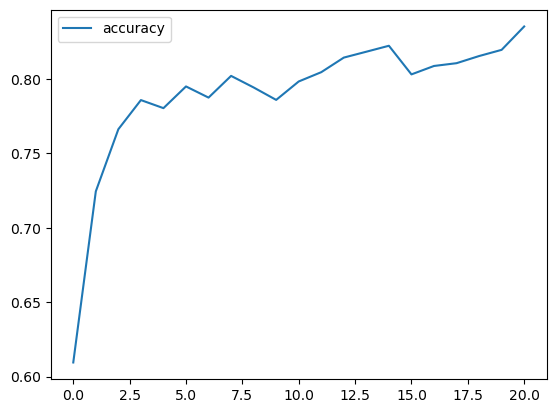

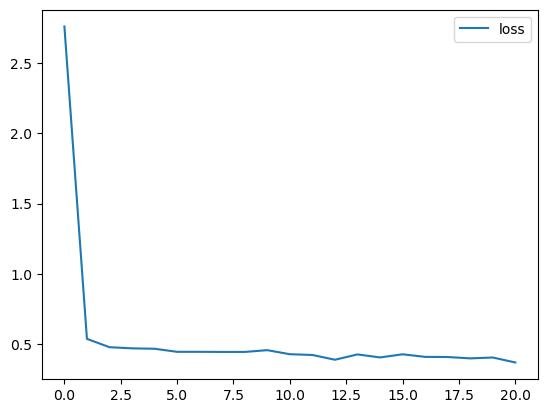

In [11]:
plt.plot(history.history['acc'], label='accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.legend()

# Test the model on the test data

1/1 [==============================] - 1s 1s/step


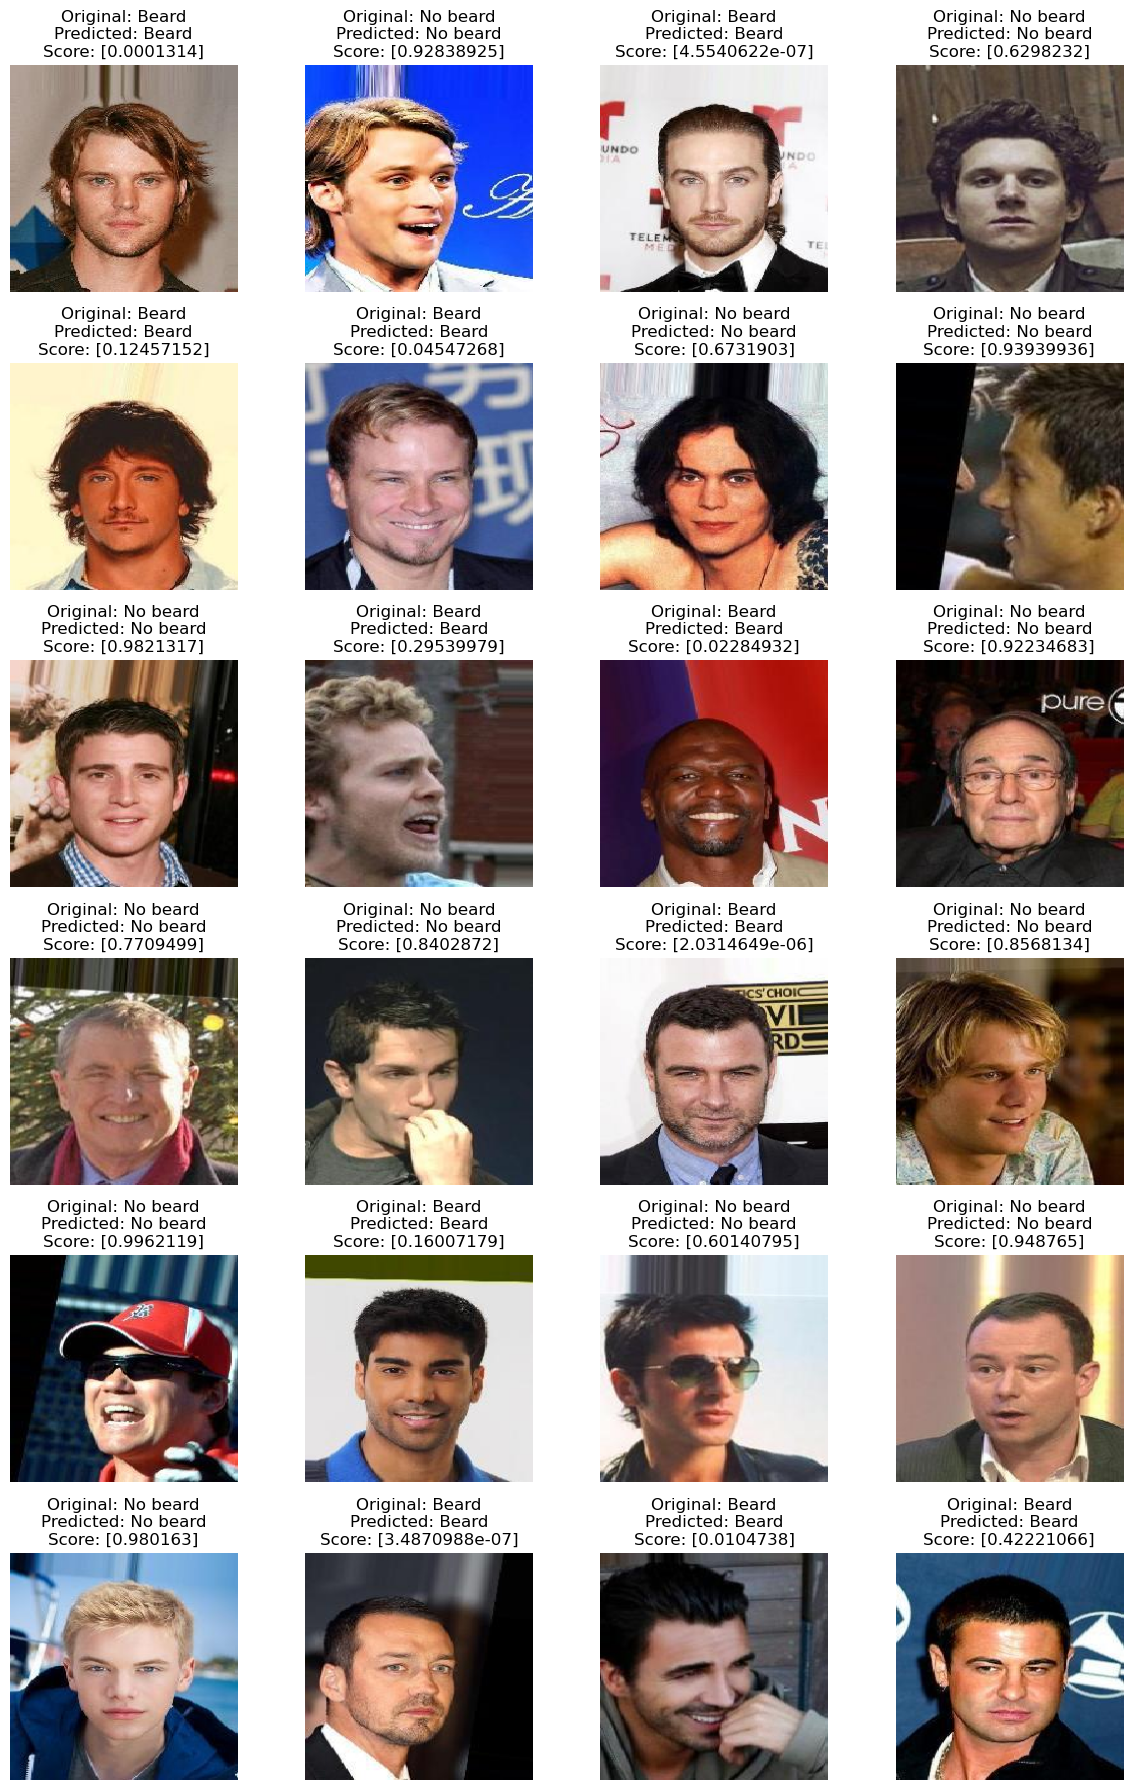

In [12]:
x_batch, y_batch = next(test_gen)
predictions = model.predict(x_batch)

# print(f"Predictions {predictions}")
predicted_labels = (predictions > 0.5).astype(int).flatten()
# print(predicted_labels)

num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

class_names = ["Beard", "No beard"]

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])
    
    true_label = class_names[int(y_batch[i])]
    predicted_label = class_names[predicted_labels[i]]
    
    ax.set_title(f"Original: {true_label}\nPredicted: {predicted_label}\nScore: {predictions[i]}")
    ax.axis('off')
    
plt.tight_layout()
plt.show()

# Test the model on my own data

1/1 [==============================] - 1s 1s/step


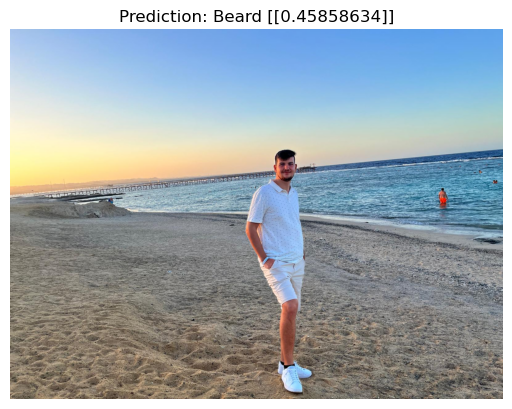

1/1 [==============================] - 0s 36ms/step


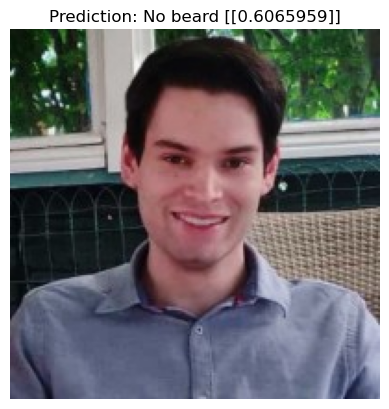

1/1 [==============================] - 0s 31ms/step


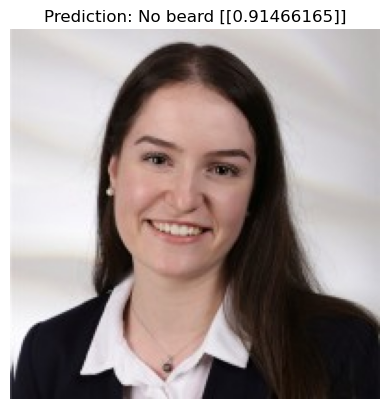

1/1 [==============================] - 0s 36ms/step


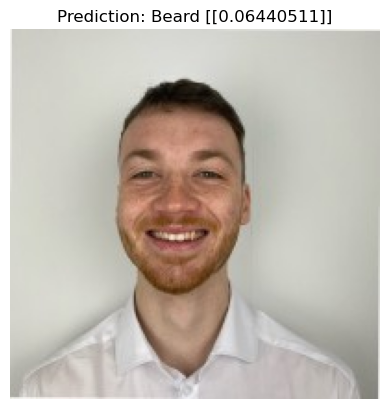

In [13]:
def edit_image(image_path: str) -> np.array: 
    img = load_img(image_path, target_size=target_size)

    img_array = img_to_array(img)
    img_array = img_array / 255.0 

    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

class_names = ["Beard", "No beard"]

images = glob.glob('../Images/*.jpg')

for i, image in enumerate(images):
    img_array = edit_image(image)
    
    prediction = model.predict(img_array)
    predicted_labels = (prediction > 0.5).astype(int).flatten()
    predicted_label = class_names[predicted_labels[0]]

    plt.imshow(load_img(image))
    plt.title(f"Prediction: {predicted_label} {prediction}")
    plt.axis("off")
    plt.show()

# Evaluate the model ans save it to a file

In [14]:
model.evaluate(test_gen)
model.save("../Models/Beard_classification.keras")

34/34 [==============================] - 1s 36ms/step - loss: 0.3740 - acc: 0.8462


# Test the model on detected and extracted faces

1/1 [==============================] - 0s 31ms/step


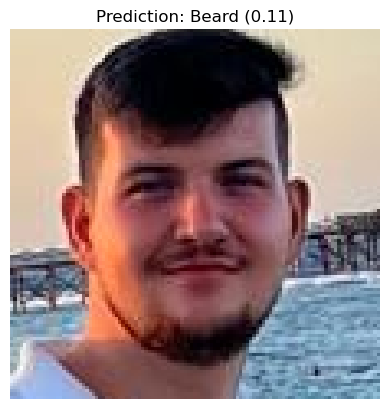

1/1 [==============================] - 0s 29ms/step


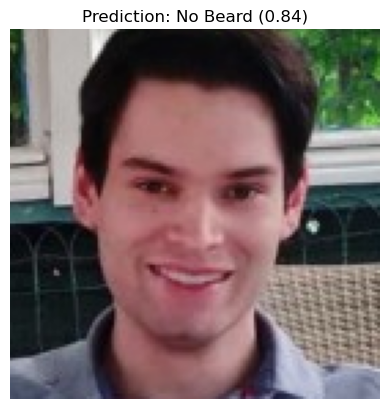

1/1 [==============================] - 0s 33ms/step


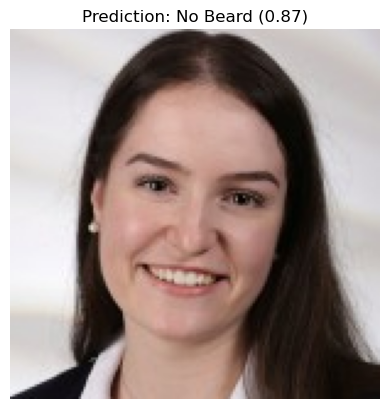

1/1 [==============================] - 0s 34ms/step


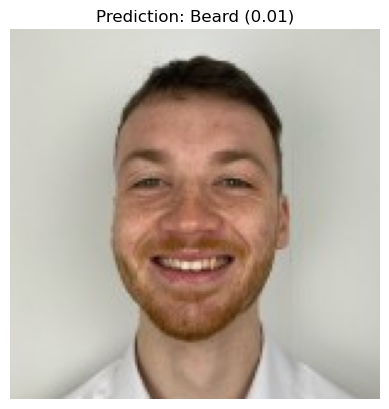

In [32]:
try:
    model
except NameError:
    model = None

if not isinstance(model, Sequential):
    print("Model not defined or not a Sequential model – loading from file...")
    model = load_model("../Models/Beard_classification.keras")

predict_detected_faces(model=model, class_names=["Beard", "No Beard"], padding=0.3)